<a href="https://colab.research.google.com/github/satyasri77/stock_volatality_prediction/blob/main/volataility_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install yfinance

In [ ]:
pip install arch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 12.0 MB/s eta 0:00:00


## **Imports**

In [40]:
import pandas as pd
import numpy as np
import yfinance as yf
from arch import arch_model
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


# **Why log returns are calculated instead of simple return?**
1. Log returns are calculate because log return are more normally distributed 2. Can be compounded over time. We can't add simple returns to get monthly weekly returns.
3. Log returns do handle extreme values well
4. Log returns are often more normally distributed (important for models assuming Gaussian errors like GARCH).

In [ ]:

data = yf.download('^GSPC', start='2010-01-01', end='2024-12-31')

data['log_return'] = np.log(data['Close'] / data['Close'].shift(1))
data.dropna(inplace=True)

print(data[['Close', 'log_return']].head())


/tmp/ipython-input-7-3200384765.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download('^GSPC', start='2010-01-01', end='2024-12-31')
[*********************100%***********************]  1 of 1 completed

Price             Close log_return
Ticker            ^GSPC           
Date                              
2010-01-05  1136.520020   0.003111
2010-01-06  1137.140015   0.000545
2010-01-07  1141.689941   0.003993
2010-01-08  1144.979980   0.002878
2010-01-11  1146.979980   0.001745


In [ ]:
data

Price,Close,High,Low,Open,Volume,log_return
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,
Date,,,,,,
2010-01-05,1136.520020,1136.630005,1129.660034,1132.660034,2491020000,0.003111
2010-01-06,1137.140015,1139.189941,1133.949951,1135.709961,4972660000,0.000545
2010-01-07,1141.689941,1142.459961,1131.319946,1136.270020,5270680000,0.003993
2010-01-08,1144.979980,1145.390015,1136.219971,1140.520020,4389590000,0.002878
2010-01-11,1146.979980,1149.739990,1142.020020,1145.959961,4255780000,0.001745
...,...,...,...,...,...,...
2024-12-23,5974.069824,5978.250000,5902.569824,5940.250000,3593280000,0.007261
2024-12-24,6040.040039,6040.100098,5981.439941,5984.629883,1757720000,0.010982


# **Garch model**
Garch(p,q) -- p and q are orders here
here p means lag of past forecasted variance - number of lagged GARCH terms
q means lag of past squared residuals/errors - number of lagged ARCH terms


ARCH part: "Was yesterday’s return unusually large?"
→ If yes, expect higher volatility tomorrow.
GARCH part: "Has volatility been high lately overall?"
→ If yes, expect high volatility to persist.


GARCH(1,1) Formula
The model estimates the **conditional variance **
**σ²_t = ω + (α₁ * ε²_{t−1}) + (β₁ * σ²_{t−1}) **


ω: constant (baseline volatility)

σ²_{t−1} = previous forecasted variance

α₁ = weight of recent shock (error terms) (ARCH effect)/How much that shock influences current volatility.

β₁ = weight of past volatility (GARCH effect)



In [ ]:
#Fit GARCH

returns = (data['log_return'].dropna())*100

garch_model = arch_model(returns, vol='Garch', p=1, q=1)
garch_fit = garch_model.fit(disp='off')

#GARCH outputs
data['garch_vol'] = garch_fit.conditional_volatility
data['garch_resid'] = garch_fit.resid / garch_fit.conditional_volatility


data

Price,Close,High,Low,Open,Volume,log_return,garch_vol,garch_resid
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,,,
Date,,,,,,,,
2010-01-05,1136.520020,1136.630005,1129.660034,1132.660034,2491020000,0.003111,0.972688,0.238715
2010-01-06,1137.140015,1139.189941,1133.949951,1135.709961,4972660000,0.000545,0.897579,-0.027130
2010-01-07,1141.689941,1142.459961,1131.319946,1136.270020,5270680000,0.003993,0.827110,0.387414
2010-01-08,1144.979980,1145.390015,1136.219971,1140.520020,4389590000,0.002878,0.776852,0.268867
2010-01-11,1146.979980,1149.739990,1142.020020,1145.959961,4255780000,0.001745,0.727355,0.131483
...,...,...,...,...,...,...,...,...
2024-12-23,5974.069824,5978.250000,5902.569824,5940.250000,3593280000,0.007261,1.206640,0.536363
2024-12-24,6040.040039,6040.100098,5981.439941,5984.629883,1757720000,0.010982,1.129227,0.902684


# **Objective and Target variable**
Use past returns, GARCH conditional volatility, and GARCH residuals to predict the future realized volatility (over the next 5 days).


**Shifting 1** back is because we want log_returns of future for suppose from t+1 to t+5 not from t to t+4 for t data point.. for future forecast of returns we need to shift back one step

In [ ]:
data['future_vol'] = data['log_return'].rolling(5).std().shift(-1)


In [ ]:
data.dropna(inplace=True)

# **My LSTM model is predicting**
Next 5-day realized volatility, based on past 10 days of:
1. Returns

2. GARCH-predicted volatility

3. GARCH residuals using LSTM Model

Creating train data using last 10 days of log_returns, garch volumne and garch residuals as one list as one data point for the prediction

In [ ]:
window = 10

X = []
y = []

features = ['log_return', 'garch_vol', 'garch_resid']

for i in range(window, len(data)-1):
    X.append(data[features].iloc[i-window:i].values)
    y.append(data['future_vol'].iloc[i])

X = np.array(X)
y = np.array(y).reshape(-1, 1)

In [ ]:
y

array([[0.0109873 ],
       [0.01290811],
       [0.01158146],
       ...,
       [0.01722301],
       [0.00584675],
       [0.00938737]])

In [ ]:
# Normalize Features

scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X.reshape(-1, nfeatures)).reshape(X.shape)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y)


In [ ]:
# Train/Test Split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, shuffle=False)


3

In [43]:
# Build and train LSTM Model

nfeatures = X.shape[2]


model = Sequential()

model.add(LSTM(units=64, return_sequences=True, input_shape=(window, nfeatures)))
model.add(Dropout(0.2))

model.add(LSTM(units=32, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(16, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

model.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 10, 64)         │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,369 (118.63 KB)

 Trainable params: 30,369 (118.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.0061 - val_loss: 0.0022
Epoch 2/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0042 - val_loss: 0.0020
Epoch 3/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0035 - val_loss: 0.0018
Epoch 4/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0034 - val_loss: 0.0015
Epoch 5/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0025 - val_loss: 0.0014
Epoch 6/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0027 - val_loss: 0.0012
Epoch 7/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0024 - val_loss: 0.0012
Epoch 8/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0023 - val_loss: 0.0012
Epoch 9/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0022 - val_loss: 0.0012
Epoch 10/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0020 - val_loss: 0.0010
Epoch 11/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0021 - val_loss: 0.0013
Epoch 12/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step

# **Inverse** **transform**
Because my dependent variable is log tranformed, I need to inverse transform to get the actual values

In [44]:
# Evaluate & Predict

y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


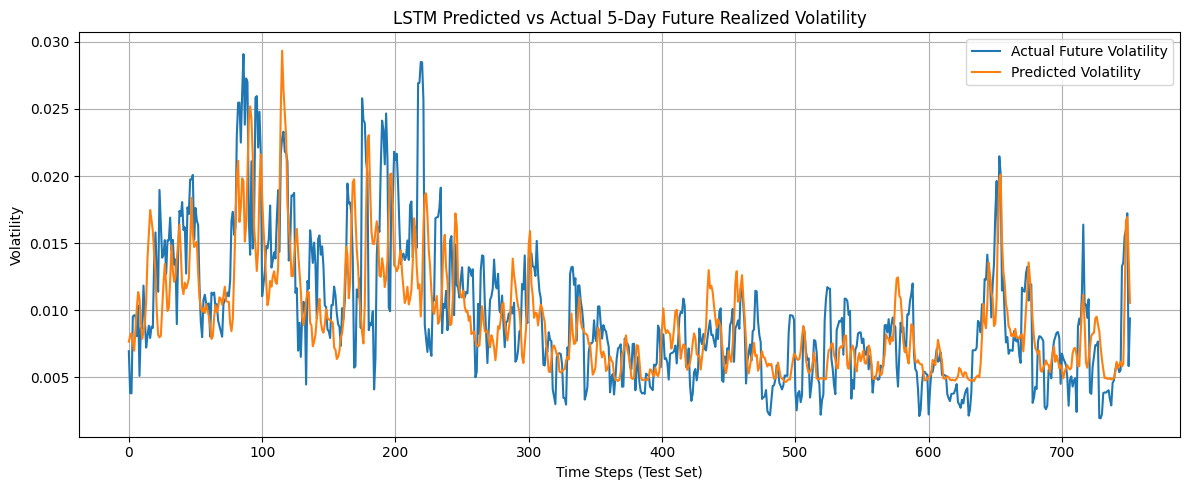

In [45]:
# Plot Predictions

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(y_test_actual, label='Actual Future Volatility')
plt.plot(y_pred, label='Predicted Volatility')
plt.title("LSTM Predicted vs Actual 5-Day Future Realized Volatility")
plt.xlabel("Time Steps (Test Set)")
plt.ylabel("Volatility")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()